In [1]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from conv_concept.model import ConvConcept
from main_dataset import CHMainDataset, SingleCropGenerator
from chunkified_npset import ChunkifiedDataset
from loss import MS_SSIMLoss
import os

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Setup dataset and dataloader

In [ ]:
np_set = ChunkifiedDataset()
gen = SingleCropGenerator(np_set[0].shape[0], np_set[0].shape[1])
dataset = CHMainDataset(np_set, gen)

Training Setup

In [3]:
BATCH_LEN = 4 #still depends on its_til_update for true loss batch size
EPOCHS = 20

In [ ]:
cl_loader = DataLoader(dataset, batch_size=BATCH_LEN)

In [ ]:
model = ConvConcept()

Training utilities
# wow

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = MS_SSIMLoss(channels=24)

Training loop definition

In [4]:
dir_to_save = 'basic_perceiver_models'
if not os.path.isdir(dir_to_save):
    os.makedirs(dir_to_save)

In [5]:
def train_epoch(dataloader, model, optimizer, criterion, losses, epoch_losses, epoch):
    its_til_checkpoint = 20
    its_til_update = 4
    
    epoch_running_loss = 0
    epoch_count = 0
    running_loss = 0
    count = 0
    optimizer.zero_grad()
    for i, (features, targets) in enumerate(dataloader):
        features = features.to(device)
        targets = targets.to(device)

        predictions = model(features)

        loss = criterion(predictions.unsqueeze(2), targets.unsqueeze(2))
        loss.backward()

        curr_len = features.shape[0]
        running_loss += curr_len * loss.item()
        count += curr_len
        epoch_running_loss += curr_len * loss.item()
        epoch_count += curr_len
        
        if i % its_til_update == its_til_update-1:
            print(f'Peforming update on model with batch_size - {its_til_update * BATCH_LEN}')
            optimizer.step()
            optimizer.zero_grad()
        
        print(f'Iteration {i} - batch size: {curr_len}')
        
        if i % its_til_checkpoint == its_til_checkpoint-1:
            curr_loss = running_loss / count
            print(f'Current loss after {its_til_checkpoint} iterations: {curr_loss}')
            losses.append(curr_loss)

            plt.plot(losses, 'b-')
            plt.title("Loss over iterations")
            plt.show()

            file_name = f'epoch-{epoch}_iteration-{i}_loss-{curr_loss}'
            torch.save(model.state_dict(), os.path.join(dir_to_save, file_name))

            running_loss = 0
            count = 0
            
        if i == 120: #rando early break lul
            break
    
    epoch_losses.append(epoch_running_loss / epoch_count)

In [6]:
losses = []
train_epoch(cl_loader, model, optimizer, criterion, losses, 0)

NameError: name 'cl_loader' is not defined

In [6]:
def train(epochs, dataset, batch_size, model, optimizer, criterion):
    losses = []
    epoch_losses = []
    dataloader = DataLoader(dataset, batch_size=batch_size)
    for epoch in range(epochs):
        print(f'Entering epoch {epoch}')
        train_epoch(dataloader, model, optimizer, criterion, losses, epoch_losses, epoch)
        print(f'Loss for epoch {epoch} - {epoch_losses[-1]}')
        plt.plot(epoch_losses, 'r-')
        plt.title('Epoch Losses')
        plt.show()
    
    return losses

In [7]:
# preprocess = ImagesPreprocess()
# model = PerceiverCH(preprocess, latent_dim=(32, 128), heads=8, wide_factor=4, latent_count=6)
model = ConvConcept()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = MS_SSIMLoss(channels=24)
np_set = ChunkifiedDataset()
gen = SingleCropGenerator(np_set[0].shape[0], np_set[0].shape[1])
dataset = CHMainDataset(np_set, gen)
dataset[0][1].shape

(24, 64, 64)

Entering epoch 0
Iteration 0 - batch size: 4
Iteration 1 - batch size: 4
Iteration 2 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 3 - batch size: 4
Iteration 4 - batch size: 4
Iteration 5 - batch size: 4
Iteration 6 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 7 - batch size: 4
Iteration 8 - batch size: 4
Iteration 9 - batch size: 4
Iteration 10 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 11 - batch size: 4
Iteration 12 - batch size: 4
Iteration 13 - batch size: 4
Iteration 14 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 15 - batch size: 4
Iteration 16 - batch size: 4
Iteration 17 - batch size: 4
Iteration 18 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 19 - batch size: 4
Current loss after 20 iterations: 0.6274245023727417


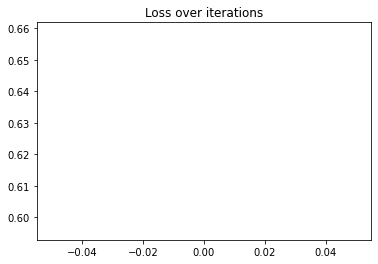

Iteration 20 - batch size: 4
Iteration 21 - batch size: 4
Iteration 22 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 23 - batch size: 4
Iteration 24 - batch size: 4
Iteration 25 - batch size: 4
Iteration 26 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 27 - batch size: 4
Iteration 28 - batch size: 4
Iteration 29 - batch size: 4
Iteration 30 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 31 - batch size: 4
Iteration 32 - batch size: 4
Iteration 33 - batch size: 4
Iteration 34 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 35 - batch size: 4
Iteration 36 - batch size: 4
Iteration 37 - batch size: 4
Iteration 38 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 39 - batch size: 4
Current loss after 20 iterations: 0.4136527836322784


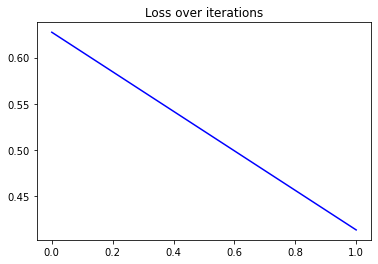

Iteration 40 - batch size: 4
Iteration 41 - batch size: 4
Iteration 42 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 43 - batch size: 4
Iteration 44 - batch size: 4
Iteration 45 - batch size: 4
Iteration 46 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 47 - batch size: 4
Iteration 48 - batch size: 4
Iteration 49 - batch size: 4
Iteration 50 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 51 - batch size: 4
Iteration 52 - batch size: 4
Iteration 53 - batch size: 4
Iteration 54 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 55 - batch size: 4
Iteration 56 - batch size: 4
Iteration 57 - batch size: 4
Iteration 58 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 59 - batch size: 4
Current loss after 20 iterations: 0.35326958894729615


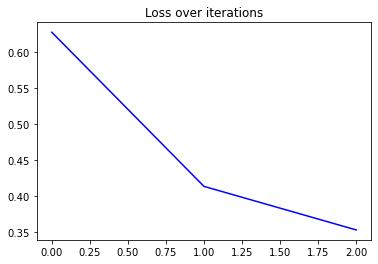

Iteration 60 - batch size: 4
Iteration 61 - batch size: 4
Iteration 62 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 63 - batch size: 4
Iteration 64 - batch size: 4
Iteration 65 - batch size: 4
Iteration 66 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 67 - batch size: 4
Iteration 68 - batch size: 4
Iteration 69 - batch size: 4
Iteration 70 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 71 - batch size: 4
Iteration 72 - batch size: 4
Iteration 73 - batch size: 4
Iteration 74 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 75 - batch size: 4
Iteration 76 - batch size: 4
Iteration 77 - batch size: 4
Iteration 78 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 79 - batch size: 4
Current loss after 20 iterations: 0.2881291091442108


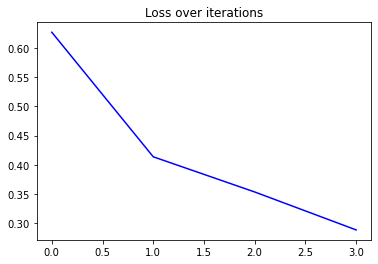

Iteration 80 - batch size: 4
Iteration 81 - batch size: 4
Iteration 82 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 83 - batch size: 4
Iteration 84 - batch size: 4
Iteration 85 - batch size: 4
Iteration 86 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 87 - batch size: 4
Iteration 88 - batch size: 4
Iteration 89 - batch size: 4
Iteration 90 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 91 - batch size: 4
Iteration 92 - batch size: 4
Iteration 93 - batch size: 4
Iteration 94 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 95 - batch size: 4
Iteration 96 - batch size: 4
Iteration 97 - batch size: 4
Iteration 98 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 99 - batch size: 4
Current loss after 20 iterations: 0.286992484331131


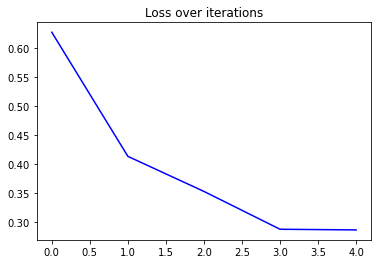

Iteration 100 - batch size: 4
Iteration 101 - batch size: 4
Iteration 102 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 103 - batch size: 4
Iteration 104 - batch size: 4
Iteration 105 - batch size: 4
Iteration 106 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 107 - batch size: 4
Iteration 108 - batch size: 4
Iteration 109 - batch size: 4
Iteration 110 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 111 - batch size: 4
Iteration 112 - batch size: 4
Iteration 113 - batch size: 4
Iteration 114 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 115 - batch size: 4
Iteration 116 - batch size: 4
Iteration 117 - batch size: 4
Iteration 118 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 119 - batch size: 4
Current loss after 20 iterations: 0.33452519178390505


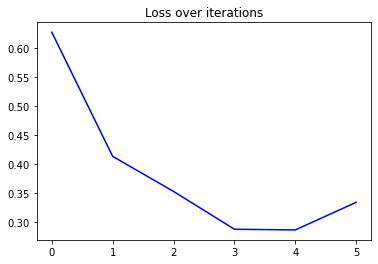

Iteration 120 - batch size: 4
Loss for epoch 0 - 0.38310666862598136


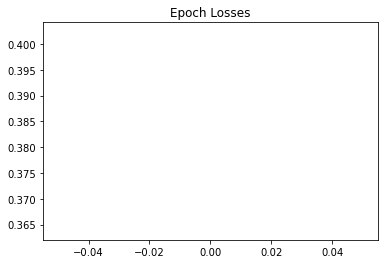

Entering epoch 1
Iteration 0 - batch size: 4
Iteration 1 - batch size: 4
Iteration 2 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 3 - batch size: 4
Iteration 4 - batch size: 4
Iteration 5 - batch size: 4
Iteration 6 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 7 - batch size: 4
Iteration 8 - batch size: 4
Iteration 9 - batch size: 4
Iteration 10 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 11 - batch size: 4
Iteration 12 - batch size: 4
Iteration 13 - batch size: 4
Iteration 14 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 15 - batch size: 4
Iteration 16 - batch size: 4
Iteration 17 - batch size: 4
Iteration 18 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 19 - batch size: 4
Current loss after 20 iterations: 0.2257675439119339


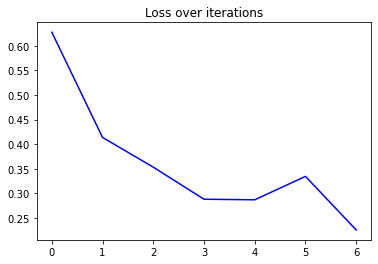

Iteration 20 - batch size: 4
Iteration 21 - batch size: 4
Iteration 22 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 23 - batch size: 4
Iteration 24 - batch size: 4
Iteration 25 - batch size: 4
Iteration 26 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 27 - batch size: 4
Iteration 28 - batch size: 4
Iteration 29 - batch size: 4
Iteration 30 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 31 - batch size: 4
Iteration 32 - batch size: 4
Iteration 33 - batch size: 4
Iteration 34 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 35 - batch size: 4
Iteration 36 - batch size: 4
Iteration 37 - batch size: 4
Iteration 38 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 39 - batch size: 4
Current loss after 20 iterations: 0.2276242196559906


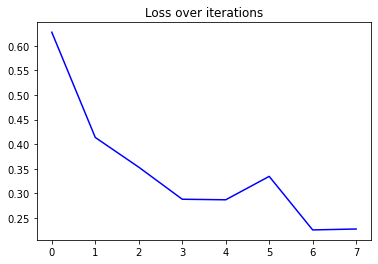

Iteration 40 - batch size: 4
Iteration 41 - batch size: 4
Iteration 42 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 43 - batch size: 4
Iteration 44 - batch size: 4
Iteration 45 - batch size: 4
Iteration 46 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 47 - batch size: 4
Iteration 48 - batch size: 4
Iteration 49 - batch size: 4
Iteration 50 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 51 - batch size: 4
Iteration 52 - batch size: 4
Iteration 53 - batch size: 4
Iteration 54 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 55 - batch size: 4
Iteration 56 - batch size: 4
Iteration 57 - batch size: 4
Iteration 58 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 59 - batch size: 4
Current loss after 20 iterations: 0.2341582179069519


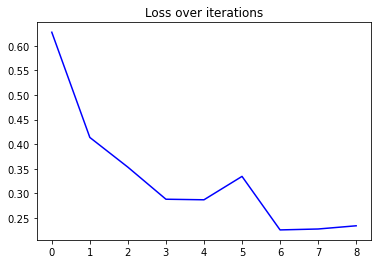

Iteration 60 - batch size: 4
Iteration 61 - batch size: 4
Iteration 62 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 63 - batch size: 4
Iteration 64 - batch size: 4
Iteration 65 - batch size: 4
Iteration 66 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 67 - batch size: 4
Iteration 68 - batch size: 4
Iteration 69 - batch size: 4
Iteration 70 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 71 - batch size: 4
Iteration 72 - batch size: 4
Iteration 73 - batch size: 4
Iteration 74 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 75 - batch size: 4
Iteration 76 - batch size: 4
Iteration 77 - batch size: 4
Iteration 78 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 79 - batch size: 4
Current loss after 20 iterations: 0.20828530490398406


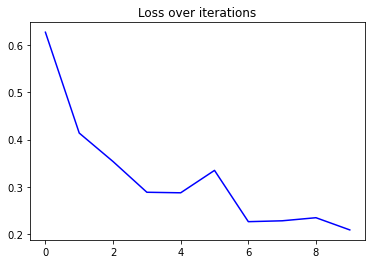

Iteration 80 - batch size: 4
Iteration 81 - batch size: 4
Iteration 82 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 83 - batch size: 4
Iteration 84 - batch size: 4
Iteration 85 - batch size: 4
Iteration 86 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 87 - batch size: 4
Iteration 88 - batch size: 4
Iteration 89 - batch size: 4
Iteration 90 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 91 - batch size: 4
Iteration 92 - batch size: 4
Iteration 93 - batch size: 4
Iteration 94 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 95 - batch size: 4
Iteration 96 - batch size: 4
Iteration 97 - batch size: 4
Iteration 98 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 99 - batch size: 4
Current loss after 20 iterations: 0.22933252155780792


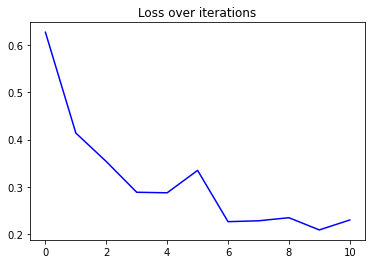

Iteration 100 - batch size: 4
Iteration 101 - batch size: 4
Iteration 102 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 103 - batch size: 4
Iteration 104 - batch size: 4
Iteration 105 - batch size: 4
Iteration 106 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 107 - batch size: 4
Iteration 108 - batch size: 4
Iteration 109 - batch size: 4
Iteration 110 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 111 - batch size: 4
Iteration 112 - batch size: 4
Iteration 113 - batch size: 4
Iteration 114 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 115 - batch size: 4
Iteration 116 - batch size: 4
Iteration 117 - batch size: 4
Iteration 118 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 119 - batch size: 4
Current loss after 20 iterations: 0.2937307596206665


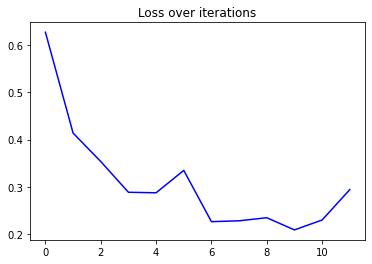

Iteration 120 - batch size: 4
Loss for epoch 1 - 0.23646972987277448


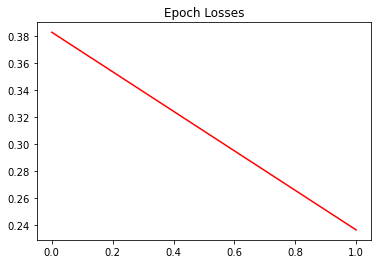

Entering epoch 2
Iteration 0 - batch size: 4
Iteration 1 - batch size: 4
Iteration 2 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 3 - batch size: 4
Iteration 4 - batch size: 4
Iteration 5 - batch size: 4
Iteration 6 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 7 - batch size: 4
Iteration 8 - batch size: 4
Iteration 9 - batch size: 4
Iteration 10 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 11 - batch size: 4
Iteration 12 - batch size: 4
Iteration 13 - batch size: 4
Iteration 14 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 15 - batch size: 4
Iteration 16 - batch size: 4
Iteration 17 - batch size: 4
Iteration 18 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 19 - batch size: 4
Current loss after 20 iterations: 0.1852744400501251


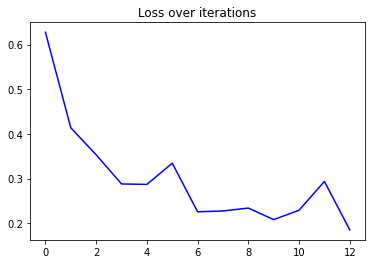

Iteration 20 - batch size: 4
Iteration 21 - batch size: 4
Iteration 22 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 23 - batch size: 4
Iteration 24 - batch size: 4
Iteration 25 - batch size: 4
Iteration 26 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 27 - batch size: 4
Iteration 28 - batch size: 4
Iteration 29 - batch size: 4
Iteration 30 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 31 - batch size: 4
Iteration 32 - batch size: 4
Iteration 33 - batch size: 4
Iteration 34 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 35 - batch size: 4
Iteration 36 - batch size: 4
Iteration 37 - batch size: 4
Iteration 38 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 39 - batch size: 4
Current loss after 20 iterations: 0.19283357560634612


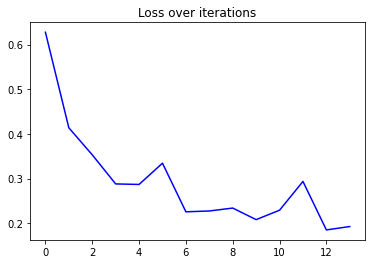

Iteration 40 - batch size: 4
Iteration 41 - batch size: 4
Iteration 42 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 43 - batch size: 4
Iteration 44 - batch size: 4
Iteration 45 - batch size: 4
Iteration 46 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 47 - batch size: 4
Iteration 48 - batch size: 4
Iteration 49 - batch size: 4
Iteration 50 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 51 - batch size: 4
Iteration 52 - batch size: 4
Iteration 53 - batch size: 4
Iteration 54 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 55 - batch size: 4
Iteration 56 - batch size: 4
Iteration 57 - batch size: 4
Iteration 58 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 59 - batch size: 4
Current loss after 20 iterations: 0.20087767839431764


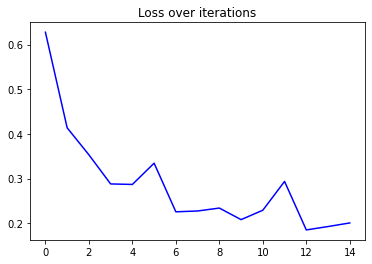

Iteration 60 - batch size: 4
Iteration 61 - batch size: 4
Iteration 62 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 63 - batch size: 4
Iteration 64 - batch size: 4
Iteration 65 - batch size: 4
Iteration 66 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 67 - batch size: 4
Iteration 68 - batch size: 4
Iteration 69 - batch size: 4
Iteration 70 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 71 - batch size: 4
Iteration 72 - batch size: 4
Iteration 73 - batch size: 4
Iteration 74 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 75 - batch size: 4
Iteration 76 - batch size: 4
Iteration 77 - batch size: 4
Iteration 78 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 79 - batch size: 4
Current loss after 20 iterations: 0.17422493398189545


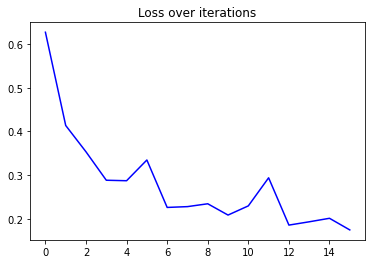

Iteration 80 - batch size: 4
Iteration 81 - batch size: 4
Iteration 82 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 83 - batch size: 4
Iteration 84 - batch size: 4
Iteration 85 - batch size: 4
Iteration 86 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 87 - batch size: 4
Iteration 88 - batch size: 4
Iteration 89 - batch size: 4
Iteration 90 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 91 - batch size: 4
Iteration 92 - batch size: 4
Iteration 93 - batch size: 4
Iteration 94 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 95 - batch size: 4
Iteration 96 - batch size: 4
Iteration 97 - batch size: 4
Iteration 98 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 99 - batch size: 4
Current loss after 20 iterations: 0.19882951080799102


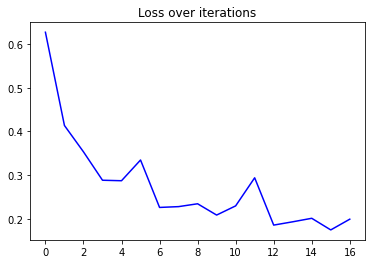

Iteration 100 - batch size: 4
Iteration 101 - batch size: 4
Iteration 102 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 103 - batch size: 4
Iteration 104 - batch size: 4
Iteration 105 - batch size: 4
Iteration 106 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 107 - batch size: 4
Iteration 108 - batch size: 4
Iteration 109 - batch size: 4
Iteration 110 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 111 - batch size: 4
Iteration 112 - batch size: 4
Iteration 113 - batch size: 4
Iteration 114 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 115 - batch size: 4
Iteration 116 - batch size: 4
Iteration 117 - batch size: 4
Iteration 118 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 119 - batch size: 4
Current loss after 20 iterations: 0.2622555524110794


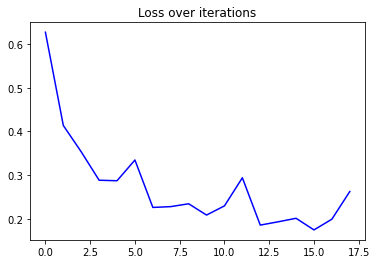

Iteration 120 - batch size: 4
Loss for epoch 2 - 0.2022878251785089


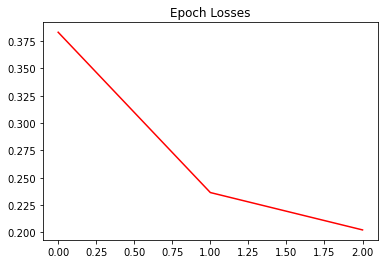

Entering epoch 3
Iteration 0 - batch size: 4
Iteration 1 - batch size: 4
Iteration 2 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 3 - batch size: 4
Iteration 4 - batch size: 4
Iteration 5 - batch size: 4
Iteration 6 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 7 - batch size: 4
Iteration 8 - batch size: 4
Iteration 9 - batch size: 4
Iteration 10 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 11 - batch size: 4
Iteration 12 - batch size: 4
Iteration 13 - batch size: 4
Iteration 14 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 15 - batch size: 4
Iteration 16 - batch size: 4
Iteration 17 - batch size: 4
Iteration 18 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 19 - batch size: 4
Current loss after 20 iterations: 0.1436546713113785


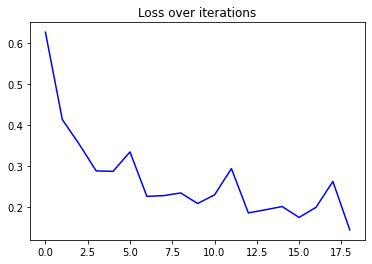

Iteration 20 - batch size: 4
Iteration 21 - batch size: 4
Iteration 22 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 23 - batch size: 4
Iteration 24 - batch size: 4
Iteration 25 - batch size: 4
Iteration 26 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 27 - batch size: 4
Iteration 28 - batch size: 4
Iteration 29 - batch size: 4
Iteration 30 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 31 - batch size: 4
Iteration 32 - batch size: 4
Iteration 33 - batch size: 4
Iteration 34 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 35 - batch size: 4
Iteration 36 - batch size: 4
Iteration 37 - batch size: 4
Iteration 38 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 39 - batch size: 4
Current loss after 20 iterations: 0.14944083988666534


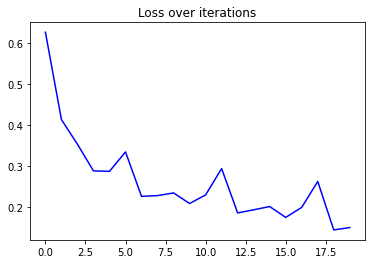

Iteration 40 - batch size: 4
Iteration 41 - batch size: 4
Iteration 42 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 43 - batch size: 4
Iteration 44 - batch size: 4
Iteration 45 - batch size: 4
Iteration 46 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 47 - batch size: 4
Iteration 48 - batch size: 4
Iteration 49 - batch size: 4
Iteration 50 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 51 - batch size: 4
Iteration 52 - batch size: 4
Iteration 53 - batch size: 4
Iteration 54 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 55 - batch size: 4
Iteration 56 - batch size: 4
Iteration 57 - batch size: 4
Iteration 58 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 59 - batch size: 4
Current loss after 20 iterations: 0.14939236044883727


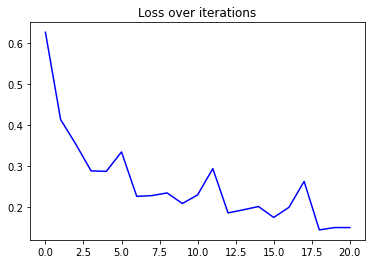

Iteration 60 - batch size: 4
Iteration 61 - batch size: 4
Iteration 62 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 63 - batch size: 4
Iteration 64 - batch size: 4
Iteration 65 - batch size: 4
Iteration 66 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 67 - batch size: 4
Iteration 68 - batch size: 4
Iteration 69 - batch size: 4
Iteration 70 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 71 - batch size: 4
Iteration 72 - batch size: 4
Iteration 73 - batch size: 4
Iteration 74 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 75 - batch size: 4
Iteration 76 - batch size: 4
Iteration 77 - batch size: 4
Iteration 78 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 79 - batch size: 4
Current loss after 20 iterations: 0.11808366179466248


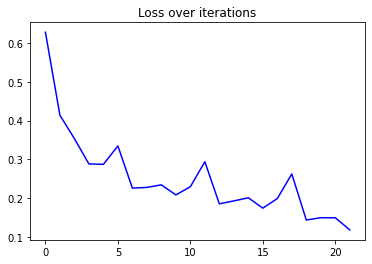

Iteration 80 - batch size: 4
Iteration 81 - batch size: 4
Iteration 82 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 83 - batch size: 4
Iteration 84 - batch size: 4
Iteration 85 - batch size: 4
Iteration 86 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 87 - batch size: 4
Iteration 88 - batch size: 4
Iteration 89 - batch size: 4
Iteration 90 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 91 - batch size: 4
Iteration 92 - batch size: 4
Iteration 93 - batch size: 4
Iteration 94 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 95 - batch size: 4
Iteration 96 - batch size: 4
Iteration 97 - batch size: 4
Iteration 98 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 99 - batch size: 4
Current loss after 20 iterations: 0.1614137828350067


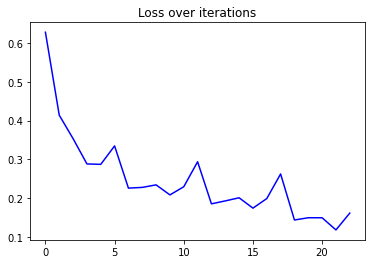

Iteration 100 - batch size: 4
Iteration 101 - batch size: 4
Iteration 102 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 103 - batch size: 4
Iteration 104 - batch size: 4
Iteration 105 - batch size: 4
Iteration 106 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 107 - batch size: 4
Iteration 108 - batch size: 4
Iteration 109 - batch size: 4
Iteration 110 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 111 - batch size: 4
Iteration 112 - batch size: 4
Iteration 113 - batch size: 4
Iteration 114 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 115 - batch size: 4
Iteration 116 - batch size: 4
Iteration 117 - batch size: 4
Iteration 118 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 119 - batch size: 4
Current loss after 20 iterations: 0.22670647799968718


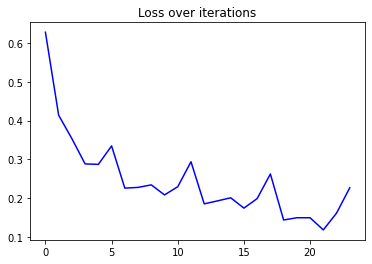

Iteration 120 - batch size: 4
Loss for epoch 3 - 0.15766932944620937


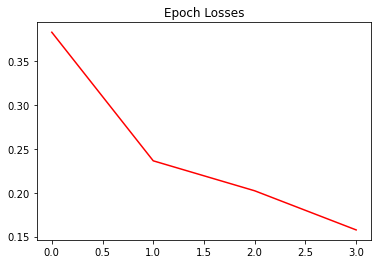

Entering epoch 4
Iteration 0 - batch size: 4
Iteration 1 - batch size: 4
Iteration 2 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 3 - batch size: 4
Iteration 4 - batch size: 4
Iteration 5 - batch size: 4
Iteration 6 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 7 - batch size: 4
Iteration 8 - batch size: 4
Iteration 9 - batch size: 4
Iteration 10 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 11 - batch size: 4
Iteration 12 - batch size: 4
Iteration 13 - batch size: 4
Iteration 14 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 15 - batch size: 4
Iteration 16 - batch size: 4
Iteration 17 - batch size: 4
Iteration 18 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 19 - batch size: 4
Current loss after 20 iterations: 0.09630286693572998


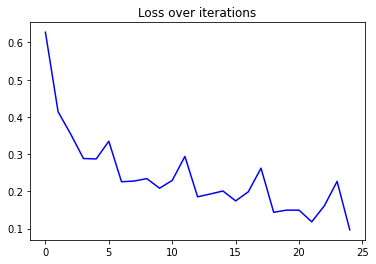

Iteration 20 - batch size: 4
Iteration 21 - batch size: 4
Iteration 22 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 23 - batch size: 4
Iteration 24 - batch size: 4
Iteration 25 - batch size: 4
Iteration 26 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 27 - batch size: 4
Iteration 28 - batch size: 4
Iteration 29 - batch size: 4
Iteration 30 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 31 - batch size: 4
Iteration 32 - batch size: 4
Iteration 33 - batch size: 4
Iteration 34 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 35 - batch size: 4
Iteration 36 - batch size: 4
Iteration 37 - batch size: 4
Iteration 38 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 39 - batch size: 4
Current loss after 20 iterations: 0.11865791082382202


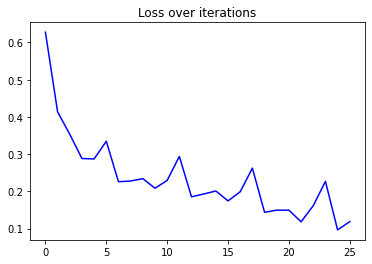

Iteration 40 - batch size: 4
Iteration 41 - batch size: 4
Iteration 42 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 43 - batch size: 4
Iteration 44 - batch size: 4
Iteration 45 - batch size: 4
Iteration 46 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 47 - batch size: 4
Iteration 48 - batch size: 4
Iteration 49 - batch size: 4
Iteration 50 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 51 - batch size: 4
Iteration 52 - batch size: 4
Iteration 53 - batch size: 4
Iteration 54 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 55 - batch size: 4
Iteration 56 - batch size: 4
Iteration 57 - batch size: 4
Iteration 58 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 59 - batch size: 4
Current loss after 20 iterations: 0.11722207069396973


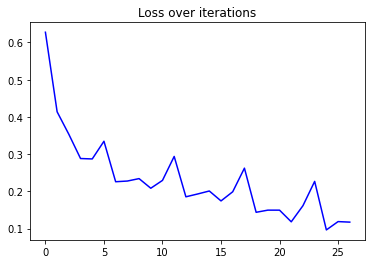

Iteration 60 - batch size: 4
Iteration 61 - batch size: 4
Iteration 62 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 63 - batch size: 4
Iteration 64 - batch size: 4
Iteration 65 - batch size: 4
Iteration 66 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 67 - batch size: 4
Iteration 68 - batch size: 4
Iteration 69 - batch size: 4
Iteration 70 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 71 - batch size: 4
Iteration 72 - batch size: 4
Iteration 73 - batch size: 4
Iteration 74 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 75 - batch size: 4
Iteration 76 - batch size: 4
Iteration 77 - batch size: 4
Iteration 78 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 79 - batch size: 4
Current loss after 20 iterations: 0.1024135023355484


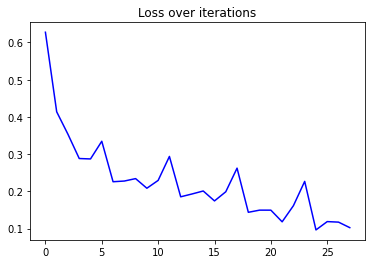

Iteration 80 - batch size: 4
Iteration 81 - batch size: 4
Iteration 82 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 83 - batch size: 4
Iteration 84 - batch size: 4
Iteration 85 - batch size: 4
Iteration 86 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 87 - batch size: 4
Iteration 88 - batch size: 4
Iteration 89 - batch size: 4
Iteration 90 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 91 - batch size: 4
Iteration 92 - batch size: 4
Iteration 93 - batch size: 4
Iteration 94 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 95 - batch size: 4
Iteration 96 - batch size: 4
Iteration 97 - batch size: 4
Iteration 98 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 99 - batch size: 4
Current loss after 20 iterations: 0.16019167602062226


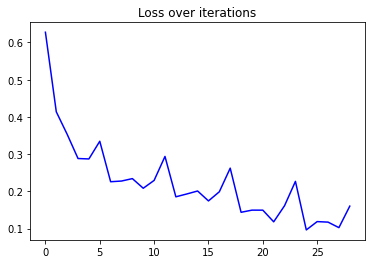

Iteration 100 - batch size: 4
Iteration 101 - batch size: 4
Iteration 102 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 103 - batch size: 4
Iteration 104 - batch size: 4
Iteration 105 - batch size: 4
Iteration 106 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 107 - batch size: 4
Iteration 108 - batch size: 4
Iteration 109 - batch size: 4
Iteration 110 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 111 - batch size: 4
Iteration 112 - batch size: 4
Iteration 113 - batch size: 4
Iteration 114 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 115 - batch size: 4
Iteration 116 - batch size: 4
Iteration 117 - batch size: 4
Iteration 118 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 119 - batch size: 4
Current loss after 20 iterations: 0.2235869437456131


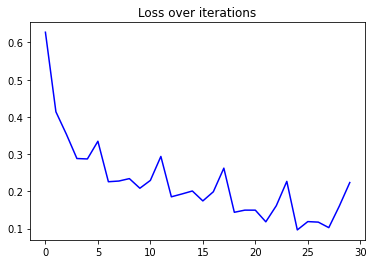

Iteration 120 - batch size: 4
Loss for epoch 4 - 0.13616225886936031


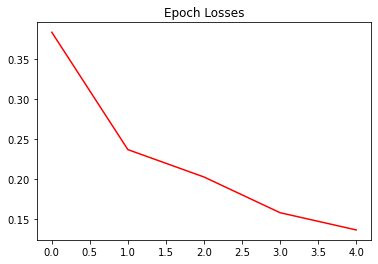

Entering epoch 5
Iteration 0 - batch size: 4
Iteration 1 - batch size: 4
Iteration 2 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 3 - batch size: 4
Iteration 4 - batch size: 4
Iteration 5 - batch size: 4
Iteration 6 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 7 - batch size: 4
Iteration 8 - batch size: 4
Iteration 9 - batch size: 4
Iteration 10 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 11 - batch size: 4
Iteration 12 - batch size: 4
Iteration 13 - batch size: 4
Iteration 14 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 15 - batch size: 4
Iteration 16 - batch size: 4
Iteration 17 - batch size: 4
Iteration 18 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 19 - batch size: 4
Current loss after 20 iterations: 0.09576271772384644


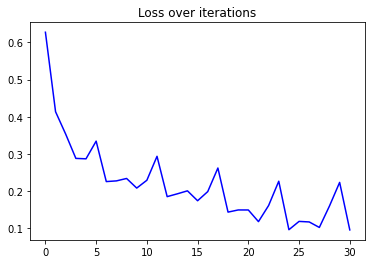

Iteration 20 - batch size: 4
Iteration 21 - batch size: 4
Iteration 22 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 23 - batch size: 4
Iteration 24 - batch size: 4
Iteration 25 - batch size: 4
Iteration 26 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 27 - batch size: 4
Iteration 28 - batch size: 4
Iteration 29 - batch size: 4
Iteration 30 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 31 - batch size: 4
Iteration 32 - batch size: 4
Iteration 33 - batch size: 4
Iteration 34 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 35 - batch size: 4
Iteration 36 - batch size: 4
Iteration 37 - batch size: 4
Iteration 38 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 39 - batch size: 4
Current loss after 20 iterations: 0.11691478490829468


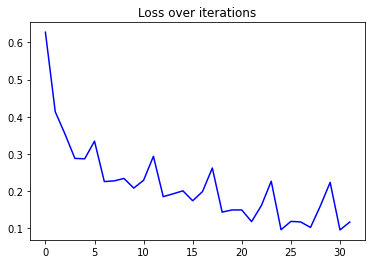

Iteration 40 - batch size: 4
Iteration 41 - batch size: 4
Iteration 42 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 43 - batch size: 4
Iteration 44 - batch size: 4
Iteration 45 - batch size: 4
Iteration 46 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 47 - batch size: 4
Iteration 48 - batch size: 4
Iteration 49 - batch size: 4
Iteration 50 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 51 - batch size: 4
Iteration 52 - batch size: 4
Iteration 53 - batch size: 4
Iteration 54 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 55 - batch size: 4
Iteration 56 - batch size: 4
Iteration 57 - batch size: 4
Iteration 58 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 59 - batch size: 4
Current loss after 20 iterations: 0.11734765172004699


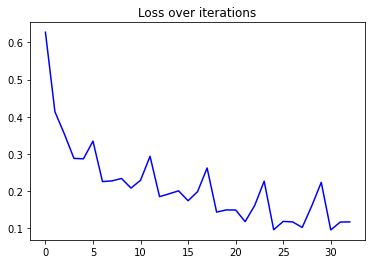

Iteration 60 - batch size: 4
Iteration 61 - batch size: 4
Iteration 62 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 63 - batch size: 4
Iteration 64 - batch size: 4
Iteration 65 - batch size: 4
Iteration 66 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 67 - batch size: 4
Iteration 68 - batch size: 4
Iteration 69 - batch size: 4
Iteration 70 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 71 - batch size: 4
Iteration 72 - batch size: 4
Iteration 73 - batch size: 4
Iteration 74 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 75 - batch size: 4
Iteration 76 - batch size: 4
Iteration 77 - batch size: 4
Iteration 78 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 79 - batch size: 4
Current loss after 20 iterations: 0.10178947746753693


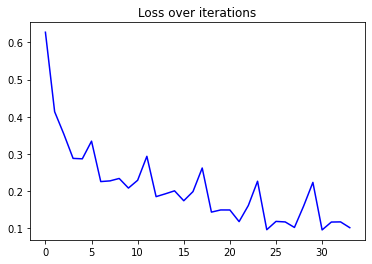

Iteration 80 - batch size: 4
Iteration 81 - batch size: 4
Iteration 82 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 83 - batch size: 4
Iteration 84 - batch size: 4
Iteration 85 - batch size: 4
Iteration 86 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 87 - batch size: 4
Iteration 88 - batch size: 4
Iteration 89 - batch size: 4
Iteration 90 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 91 - batch size: 4
Iteration 92 - batch size: 4
Iteration 93 - batch size: 4
Iteration 94 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 95 - batch size: 4
Iteration 96 - batch size: 4
Iteration 97 - batch size: 4
Iteration 98 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 99 - batch size: 4
Current loss after 20 iterations: 0.15985115468502045


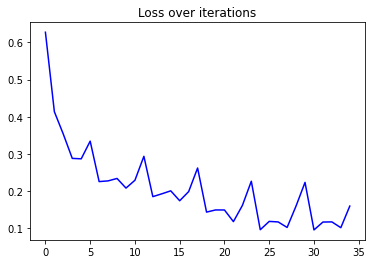

Iteration 100 - batch size: 4
Iteration 101 - batch size: 4
Iteration 102 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 103 - batch size: 4
Iteration 104 - batch size: 4
Iteration 105 - batch size: 4
Iteration 106 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 107 - batch size: 4
Iteration 108 - batch size: 4
Iteration 109 - batch size: 4
Iteration 110 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 111 - batch size: 4
Iteration 112 - batch size: 4
Iteration 113 - batch size: 4
Iteration 114 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 115 - batch size: 4
Iteration 116 - batch size: 4
Iteration 117 - batch size: 4
Iteration 118 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 119 - batch size: 4
Current loss after 20 iterations: 0.22372883260250093


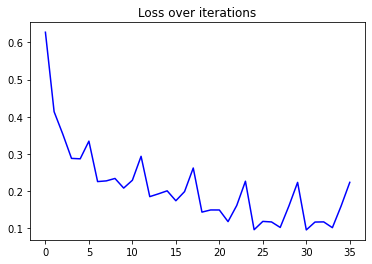

Iteration 120 - batch size: 4
Loss for epoch 5 - 0.13565278989224394


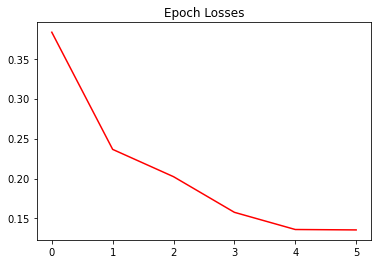

Entering epoch 6
Iteration 0 - batch size: 4
Iteration 1 - batch size: 4
Iteration 2 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 3 - batch size: 4
Iteration 4 - batch size: 4
Iteration 5 - batch size: 4
Iteration 6 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 7 - batch size: 4
Iteration 8 - batch size: 4
Iteration 9 - batch size: 4
Iteration 10 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 11 - batch size: 4
Iteration 12 - batch size: 4
Iteration 13 - batch size: 4
Iteration 14 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 15 - batch size: 4
Iteration 16 - batch size: 4
Iteration 17 - batch size: 4
Iteration 18 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 19 - batch size: 4
Current loss after 20 iterations: 0.09503663480281829


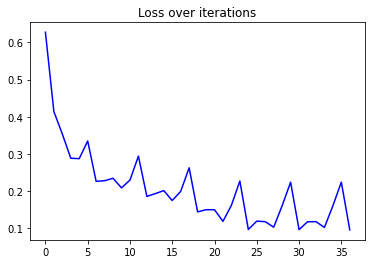

Iteration 20 - batch size: 4
Iteration 21 - batch size: 4
Iteration 22 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 23 - batch size: 4
Iteration 24 - batch size: 4
Iteration 25 - batch size: 4
Iteration 26 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 27 - batch size: 4
Iteration 28 - batch size: 4
Iteration 29 - batch size: 4
Iteration 30 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 31 - batch size: 4
Iteration 32 - batch size: 4
Iteration 33 - batch size: 4
Iteration 34 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 35 - batch size: 4
Iteration 36 - batch size: 4
Iteration 37 - batch size: 4
Iteration 38 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 39 - batch size: 4
Current loss after 20 iterations: 0.11654663383960724


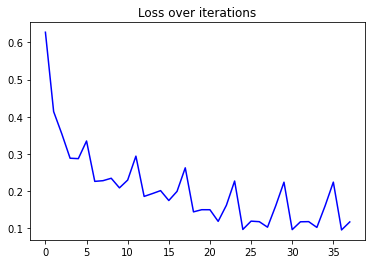

Iteration 40 - batch size: 4
Iteration 41 - batch size: 4
Iteration 42 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 43 - batch size: 4
Iteration 44 - batch size: 4
Iteration 45 - batch size: 4
Iteration 46 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 47 - batch size: 4
Iteration 48 - batch size: 4
Iteration 49 - batch size: 4
Iteration 50 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 51 - batch size: 4
Iteration 52 - batch size: 4
Iteration 53 - batch size: 4
Iteration 54 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 55 - batch size: 4
Iteration 56 - batch size: 4
Iteration 57 - batch size: 4
Iteration 58 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 59 - batch size: 4
Current loss after 20 iterations: 0.11687504351139069


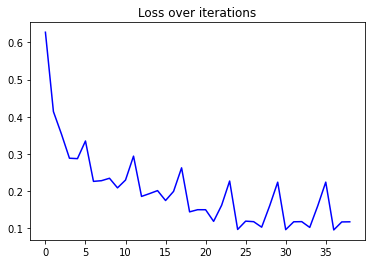

Iteration 60 - batch size: 4
Iteration 61 - batch size: 4
Iteration 62 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 63 - batch size: 4
Iteration 64 - batch size: 4
Iteration 65 - batch size: 4
Iteration 66 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 67 - batch size: 4
Iteration 68 - batch size: 4
Iteration 69 - batch size: 4
Iteration 70 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 71 - batch size: 4
Iteration 72 - batch size: 4
Iteration 73 - batch size: 4
Iteration 74 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 75 - batch size: 4
Iteration 76 - batch size: 4
Iteration 77 - batch size: 4
Iteration 78 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 79 - batch size: 4
Current loss after 20 iterations: 0.10172724425792694


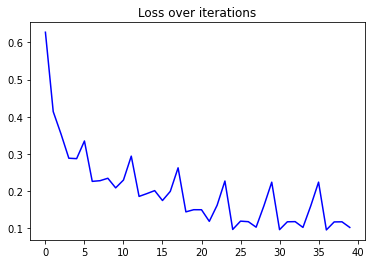

Iteration 80 - batch size: 4
Iteration 81 - batch size: 4
Iteration 82 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 83 - batch size: 4
Iteration 84 - batch size: 4
Iteration 85 - batch size: 4
Iteration 86 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 87 - batch size: 4
Iteration 88 - batch size: 4
Iteration 89 - batch size: 4
Iteration 90 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 91 - batch size: 4
Iteration 92 - batch size: 4
Iteration 93 - batch size: 4
Iteration 94 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 95 - batch size: 4
Iteration 96 - batch size: 4
Iteration 97 - batch size: 4
Iteration 98 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 99 - batch size: 4
Current loss after 20 iterations: 0.15926165282726287


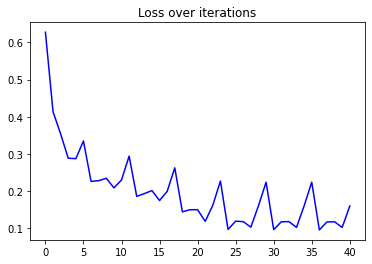

Iteration 100 - batch size: 4
Iteration 101 - batch size: 4
Iteration 102 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 103 - batch size: 4
Iteration 104 - batch size: 4
Iteration 105 - batch size: 4
Iteration 106 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 107 - batch size: 4
Iteration 108 - batch size: 4
Iteration 109 - batch size: 4
Iteration 110 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 111 - batch size: 4
Iteration 112 - batch size: 4
Iteration 113 - batch size: 4
Iteration 114 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 115 - batch size: 4
Iteration 116 - batch size: 4
Iteration 117 - batch size: 4
Iteration 118 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 119 - batch size: 4
Current loss after 20 iterations: 0.2234913855791092


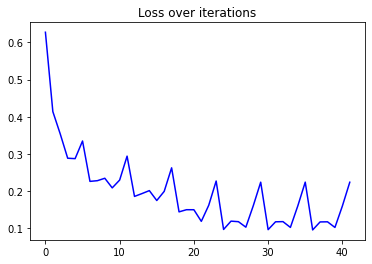

Iteration 120 - batch size: 4
Loss for epoch 6 - 0.1352508176456798


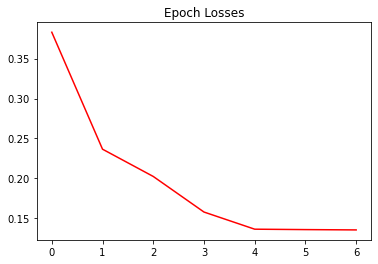

Entering epoch 7
Iteration 0 - batch size: 4
Iteration 1 - batch size: 4
Iteration 2 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 3 - batch size: 4
Iteration 4 - batch size: 4
Iteration 5 - batch size: 4
Iteration 6 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 7 - batch size: 4
Iteration 8 - batch size: 4
Iteration 9 - batch size: 4
Iteration 10 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 11 - batch size: 4
Iteration 12 - batch size: 4
Iteration 13 - batch size: 4
Iteration 14 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 15 - batch size: 4
Iteration 16 - batch size: 4
Iteration 17 - batch size: 4
Iteration 18 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 19 - batch size: 4
Current loss after 20 iterations: 0.09474251866340637


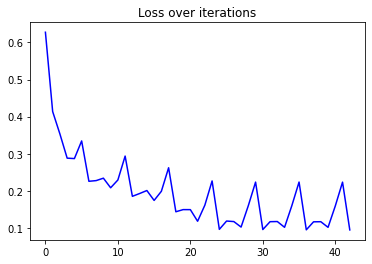

Iteration 20 - batch size: 4
Iteration 21 - batch size: 4
Iteration 22 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 23 - batch size: 4
Iteration 24 - batch size: 4
Iteration 25 - batch size: 4
Iteration 26 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 27 - batch size: 4
Iteration 28 - batch size: 4
Iteration 29 - batch size: 4
Iteration 30 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 31 - batch size: 4
Iteration 32 - batch size: 4
Iteration 33 - batch size: 4
Iteration 34 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 35 - batch size: 4
Iteration 36 - batch size: 4
Iteration 37 - batch size: 4
Iteration 38 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 39 - batch size: 4
Current loss after 20 iterations: 0.11641788184642791


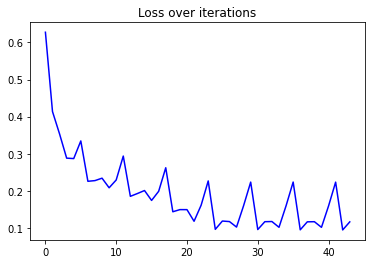

Iteration 40 - batch size: 4
Iteration 41 - batch size: 4
Iteration 42 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 43 - batch size: 4
Iteration 44 - batch size: 4
Iteration 45 - batch size: 4
Iteration 46 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 47 - batch size: 4
Iteration 48 - batch size: 4
Iteration 49 - batch size: 4
Iteration 50 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 51 - batch size: 4
Iteration 52 - batch size: 4
Iteration 53 - batch size: 4
Iteration 54 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 55 - batch size: 4
Iteration 56 - batch size: 4
Iteration 57 - batch size: 4
Iteration 58 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 59 - batch size: 4
Current loss after 20 iterations: 0.11646347045898438


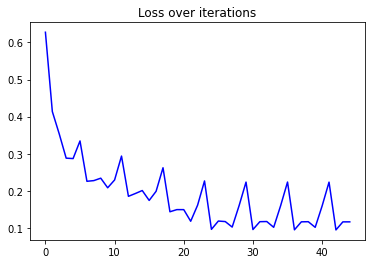

Iteration 60 - batch size: 4
Iteration 61 - batch size: 4
Iteration 62 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 63 - batch size: 4
Iteration 64 - batch size: 4
Iteration 65 - batch size: 4
Iteration 66 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 67 - batch size: 4
Iteration 68 - batch size: 4
Iteration 69 - batch size: 4
Iteration 70 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 71 - batch size: 4
Iteration 72 - batch size: 4
Iteration 73 - batch size: 4
Iteration 74 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 75 - batch size: 4
Iteration 76 - batch size: 4
Iteration 77 - batch size: 4
Iteration 78 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 79 - batch size: 4
Current loss after 20 iterations: 0.10168356895446777


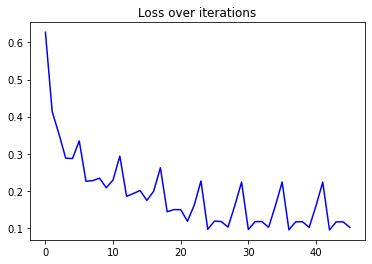

Iteration 80 - batch size: 4
Iteration 81 - batch size: 4
Iteration 82 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 83 - batch size: 4
Iteration 84 - batch size: 4
Iteration 85 - batch size: 4
Iteration 86 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 87 - batch size: 4
Iteration 88 - batch size: 4
Iteration 89 - batch size: 4
Iteration 90 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 91 - batch size: 4
Iteration 92 - batch size: 4
Iteration 93 - batch size: 4
Iteration 94 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 95 - batch size: 4
Iteration 96 - batch size: 4
Iteration 97 - batch size: 4
Iteration 98 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 99 - batch size: 4
Current loss after 20 iterations: 0.15897945165634156


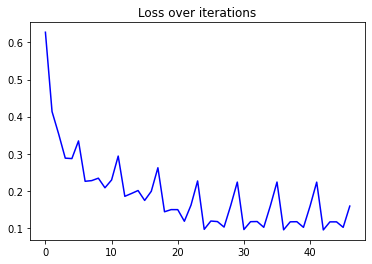

Iteration 100 - batch size: 4
Iteration 101 - batch size: 4
Iteration 102 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 103 - batch size: 4
Iteration 104 - batch size: 4
Iteration 105 - batch size: 4
Iteration 106 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 107 - batch size: 4
Iteration 108 - batch size: 4
Iteration 109 - batch size: 4
Iteration 110 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 111 - batch size: 4
Iteration 112 - batch size: 4
Iteration 113 - batch size: 4
Iteration 114 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 115 - batch size: 4
Iteration 116 - batch size: 4
Iteration 117 - batch size: 4
Iteration 118 - batch size: 4
Peforming update on model with batch_size - 16
Iteration 119 - batch size: 4
Current loss after 20 iterations: 0.223428875207901


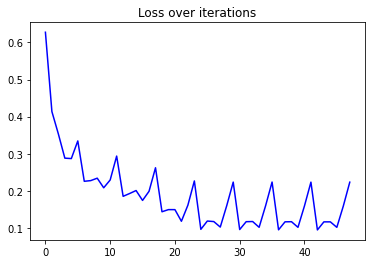

Iteration 120 - batch size: 4
Loss for epoch 7 - 0.13505403611285627


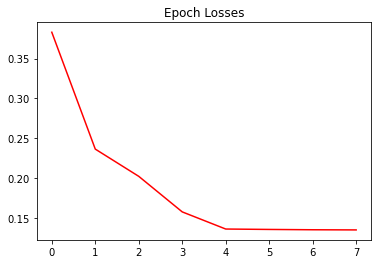

Entering epoch 8
Iteration 0 - batch size: 4
Iteration 1 - batch size: 4
Iteration 2 - batch size: 4


KeyboardInterrupt: 

In [8]:
train(EPOCHS, dataset, BATCH_LEN, model, optimizer, criterion)

#### Lets see the results


tensor([[108.1480,  89.9270, 114.2029,  ..., 109.5805, 126.3935, 113.9494],
        [105.6184, 119.5060, 102.8488,  ..., 108.8656, 108.4611, 115.2953],
        [118.0444, 105.7162, 103.1972,  ..., 106.8358, 105.8776, 111.6429],
        ...,
        [105.5397, 104.1343, 106.0387,  ...,  97.2158,  97.7415, 100.1439],
        [111.0682, 111.1570, 103.2178,  ...,  98.5150, 100.4763, 103.2372],
        [102.5763,  94.9151, 109.7924,  ...,  99.4999, 102.9359, 103.5518]])
tensor([[108.2142,  89.8417, 114.1123,  ..., 109.5654, 126.4732, 113.9136],
        [105.4905, 119.5252, 102.8016,  ..., 108.7787, 108.4762, 115.4736],
        [117.9746, 105.7142, 103.1574,  ..., 106.8486, 105.8943, 111.6288],
        ...,
        [105.5729, 104.1638, 106.0321,  ...,  97.1761,  97.7923, 100.2169],
        [110.9664, 111.0117, 103.1829,  ...,  98.5320, 100.4354, 103.2919],
        [102.5644,  94.9712, 109.7789,  ...,  99.5432, 102.8670, 103.5070]])
tensor([[108.2766,  89.8220, 114.1094,  ..., 109.5903, 126.4

tensor([[109.2669,  91.2931, 118.5717,  ..., 112.2741, 129.4209, 115.9363],
        [107.1450, 124.7858, 105.0004,  ..., 109.9756, 111.2779, 119.2300],
        [120.2400, 106.2295, 102.8710,  ..., 108.8716, 107.6873, 115.3430],
        ...,
        [109.4201, 108.9372, 110.0660,  ..., 101.6003, 102.5310, 105.8269],
        [115.7795, 116.1507, 105.9613,  ..., 105.1817, 105.4646, 107.6600],
        [107.0959,  97.7946, 112.9383,  ..., 103.7610, 106.7982, 109.8735]])
tensor([[109.3091,  91.2379, 118.4989,  ..., 112.2654, 129.4764, 115.9169],
        [107.0557, 124.8023, 104.9668,  ..., 109.9248, 111.2891, 119.3525],
        [120.1915, 106.2301, 102.8463,  ..., 108.8761, 107.6958, 115.3377],
        ...,
        [109.4469, 108.9553, 110.0606,  ..., 101.5663, 102.5708, 105.8807],
        [115.6983, 116.0567, 105.9272,  ..., 105.1921, 105.4295, 107.6879],
        [107.0863,  97.8306, 112.9289,  ..., 103.7901, 106.7385, 109.8445]])
tensor([[109.3482,  91.2260, 118.4946,  ..., 112.2783, 129.4

tensor([[108.2811,  89.9954, 114.4800,  ..., 109.6967, 126.5260, 114.0195],
        [105.7001, 119.8695, 103.0152,  ..., 109.0206, 108.5199, 115.4214],
        [118.1635, 105.7917, 103.1257,  ..., 106.9084, 105.9467, 111.8803],
        ...,
        [105.6760, 104.3365, 106.2380,  ...,  97.4399,  97.9486, 100.3891],
        [111.2974, 111.3998, 103.2908,  ...,  98.8415, 100.7347, 103.4531],
        [102.7229,  95.0412, 109.9218,  ...,  99.6858, 103.0730, 103.8258]])
tensor([[108.3455,  89.9111, 114.3902,  ..., 109.6828, 126.6039, 113.9828],
        [105.5739, 119.8888, 102.9677,  ..., 108.9354, 108.5348, 115.5978],
        [118.0954, 105.7907, 103.0872,  ..., 106.9203, 105.9627, 111.8662],
        ...,
        [105.7089, 104.3652, 106.2309,  ...,  97.4005,  97.9982, 100.4609],
        [111.1966, 111.2567, 103.2564,  ...,  98.8582, 100.6935, 103.5062],
        [102.7109,  95.0972, 109.9083,  ...,  99.7277, 103.0045, 103.7816]])
tensor([[108.4061,  89.8917, 114.3869,  ..., 109.7071, 126.5

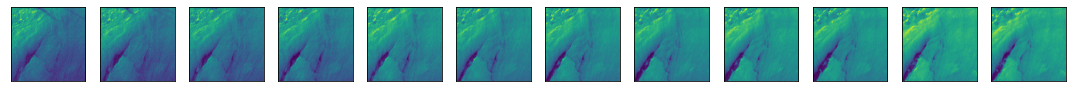

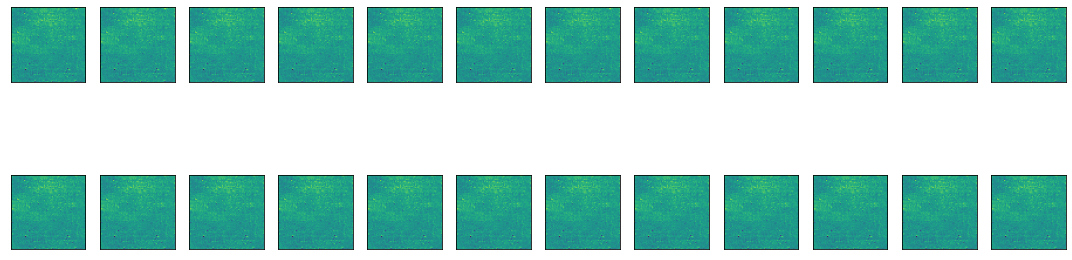

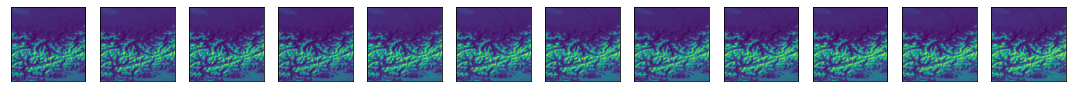

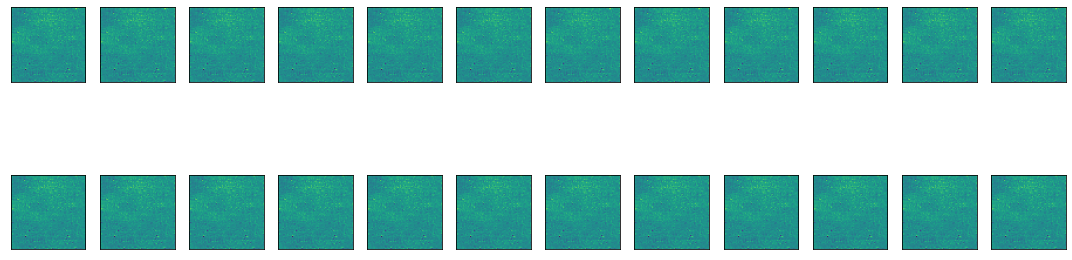

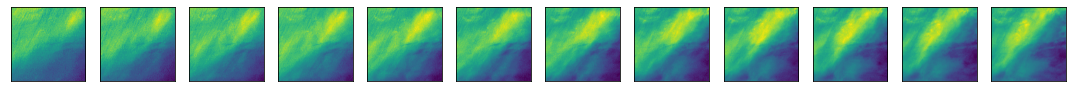

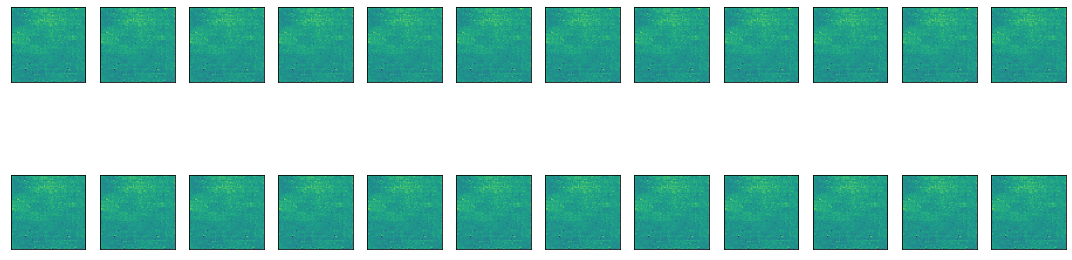

In [10]:
model.eval()
garbo = [dataset[i] for i in range(10, 13)]
for i, (features, targets) in enumerate(garbo):
    if i == 3:
        break
    
    fig, axs = plt.subplots(1, 12, figsize=(15, 3))
    for f_no, ax in enumerate(axs):
        ax.imshow(features[f_no], cmap='viridis')
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
    fig.tight_layout()
    fig.show()
    
    features = torch.tensor(features).unsqueeze(0).to(device)
    predictions = model(features)
    fig, axs = plt.subplots(2, 12, figsize=(15, 6))
    predictions = predictions.squeeze()
    predictions = predictions.detach().cpu()
    p_no = 0
    for chonky in axs:
        for ax in chonky:
            ax.imshow(predictions[p_no], cmap='viridis')
            ax.get_yaxis().set_visible(False)
            ax.get_xaxis().set_visible(False)
            print(predictions[p_no])
            p_no += 1
    fig.tight_layout()
    
    fig.show()

In [14]:
print(torch.mean(model.process.q_out))

tensor(-1.7162e-05, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
plt.plot(losses, 'b-')
plt.set_title("THe losses wow")
plt.show()